In [1]:
%reload_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import copy
import gc
import math
import random
from pathlib import Path
from PIL import Image
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

import cv2
from easydict import EasyDict
from tqdm.notebook import tqdm
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import pytorch_lightning as pl

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)

<IPython.core.display.Javascript object>

In [3]:
args = dict(
    seed=42,
    num_plants=8,
    num_diseases=14,
    plant2idx={3: 0, 4: 1, 5: 2, 7: 3, 8: 4, 10: 5, 11: 6, 13: 7},
    disease2idx={
        1: 0,
        2: 1,
        5: 2,
        6: 3,
        7: 4,
        8: 5,
        9: 6,
        11: 7,
        14: 8,
        15: 9,
        16: 10,
        17: 11,
        18: 12,
        20: 13,
    },
    # Data
    model_path=Path("/home/isleof/Development/nipa/models"),
    data_path=Path("/home/isleof/Development/nipa/input/train"),
    data_path_128=Path("/home/isleof/Development/nipa/input/train-128"),
    train_csv=Path("/home/isleof/Development/nipa/input/train_folds.csv"),
    test_csv=Path("/home/isleof/Development/nipa/input/test.csv"),
    # Model
    backbone="gluon_seresnext50_32x4d",
    # Optimizer
    optimizer="adamw",
    lr=1e-3,
    weight_decay=1e-4,
    scheduler={"method": "cosine", "warmup_epochs": 1},
    # Train
    gradient_accumulation_steps=1,
    precision=16,
    num_workers=4,
    batch_size=128,
    max_epochs=30,
)

args["trn_aug"] = A.Compose(
    [
        A.OneOf(
            [
                A.IAAAdditiveGaussianNoise(p=1),
                A.GaussNoise(p=1),
            ],
            p=0.5,
        ),
        A.OneOf(
            [
                A.RandomBrightnessContrast(
                    brightness_limit=0.1, contrast_limit=0.1, p=1
                ),
                A.CLAHE(clip_limit=3, p=1),
                A.IAASharpen(p=1),
                A.IAAEmboss(p=1),
            ],
            p=0.5,
        ),
        A.OneOf(
            [
                A.MotionBlur(blur_limit=3, p=1),
                A.MedianBlur(blur_limit=3, p=1),
                A.GaussianBlur(p=1),
            ],
            p=0.5,
        ),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=20, p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ]
)

args["val_aug"] = A.Compose([A.Normalize(), ToTensorV2()])

<IPython.core.display.Javascript object>

## Setup

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


seed_everything(args["seed"])

<IPython.core.display.Javascript object>

In [5]:
def visualize(dataset, idx=0):
    data = dataset[idx]
    img = data["img"]
    plant = data["plant"]
    disease = data["disease"]
    print(plant, disease)
    plt.imshow(img)
    plt.axis("off")


def visualize_tfms(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.tfms = A.Compose(
        [t for t in dataset.tfms if not isinstance(t, (A.Normalize, ToTensorV2))]
    )
    rows = samples // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
    for i, ax in enumerate(axes.flat):
        img = dataset[idx]["img"]
        ax.imshow(img)
        ax.set_axis_off()
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>

In [6]:
# df = pd.read_csv(
#     PATH / "train.tsv", sep="\t", header=None, names=["img", "plant", "disease"]
# )

<IPython.core.display.Javascript object>

In [7]:
# test_df = pd.read_csv("../input/test.tsv", sep="\t", header=None, names=["img"])
# test_df.to_csv(args.test_csv, index=False)
# test_df.head()

<IPython.core.display.Javascript object>

In [8]:
df = pd.read_csv(args["train_csv"])
df.head()

,img,plant,disease,fold
0,13_16_475.jpg,13,16,0
1,3_5_936.jpg,3,5,3
2,13_15_126.jpg,13,15,2
3,4_11_605.jpg,4,11,1
4,3_20_1113.jpg,3,20,4


<IPython.core.display.Javascript object>

In [9]:
plants = list(sorted(df.plant.unique()))
diseases = list(sorted(df.disease.unique()))
print("Plant:", plants, len(plants))
print("Disease:", diseases, len(diseases))

Plant: [3, 4, 5, 7, 8, 10, 11, 13] 8
Disease: [1, 2, 5, 6, 7, 8, 9, 11, 14, 15, 16, 17, 18, 20] 14


<IPython.core.display.Javascript object>

## k-folds

In [7]:
df = df.sample(frac=1.0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [8]:
df["fold"] = -1
y = df[["plant", "disease"]].values
kf = MultilabelStratifiedKFold(n_splits=5)
for fold, (trn_idx, val_idx) in enumerate(kf.split(df, y)):
    df.loc[val_idx, "fold"] = fold

<IPython.core.display.Javascript object>

In [9]:
df.to_csv(args["train_csv"], index=False)
df.head()

,img,plant,disease,fold
0,13_16_475.jpg,13,16,0
1,3_5_936.jpg,3,5,3
2,13_15_126.jpg,13,15,2
3,4_11_605.jpg,4,11,1
4,3_20_1113.jpg,3,20,4


<IPython.core.display.Javascript object>

## EDA

In [32]:
img_paths = list((args["data_path"]).iterdir())
img_paths[:5]

[PosixPath('/home/isleof/Development/nipa/input/train/13_17_1007.jpg'),
 PosixPath('/home/isleof/Development/nipa/input/train/4_7_830.jpg'),
 PosixPath('/home/isleof/Development/nipa/input/train/4_2_950.jpg'),
 PosixPath('/home/isleof/Development/nipa/input/train/3_20_1097.jpg'),
 PosixPath('/home/isleof/Development/nipa/input/train/8_6_616.jpg')]

<IPython.core.display.Javascript object>

(256, 256, 3)


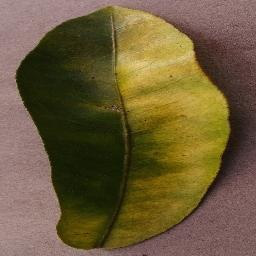

<IPython.core.display.Javascript object>

In [17]:
idx = np.random.randint(len(img_paths))
path = img_paths[idx]
img = Image.open(path).convert("RGB")
print(np.array(img).shape)
img

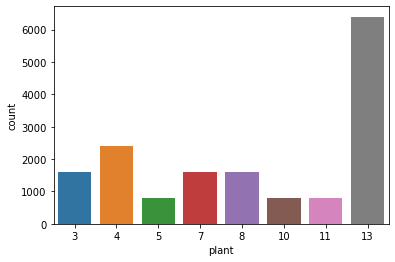

<IPython.core.display.Javascript object>

In [25]:
sns.countplot(df.plant)
plt.show()

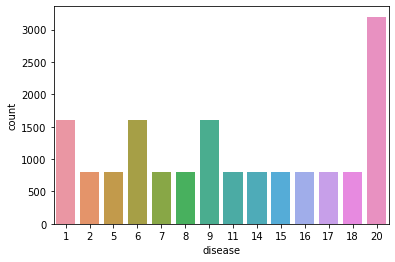

<IPython.core.display.Javascript object>

In [24]:
sns.countplot(df.disease)
plt.show()

## Resize

In [60]:
(PATH / "train-128").mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
def resize_img(fn):
    Image.open(fn).resize((128, 128)).save((fn.parent.parent) / "train-128" / fn.name)


with ThreadPoolExecutor(8) as e:
    e.map(resize_img, img_paths)

<IPython.core.display.Javascript object>

## Dataset

In [10]:
class PlantDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.imgs = df.img.values
        self.plants = [args["plant2idx"][plant] for plant in df.plant.values]
        self.diseases = [args["disease2idx"][disease] for disease in df.disease.values]
        self.tfms = tfms

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = str(args["data_path_128"] / self.imgs[idx])
        plant = self.plants[idx]
        disease = self.diseases[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.tfms is not None:
            img = self.tfms(image=img)["image"]

        plant = torch.tensor(plant, dtype=torch.long)
        disease = torch.tensor(disease, dtype=torch.long)

        return {"img": img, "plant": plant, "disease": disease}

<IPython.core.display.Javascript object>

tensor(7) tensor(0)


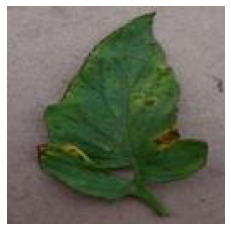

<IPython.core.display.Javascript object>

In [11]:
dataset = PlantDataset(df)
idx = np.random.randint(len(dataset))
visualize(dataset, idx)

## Transform

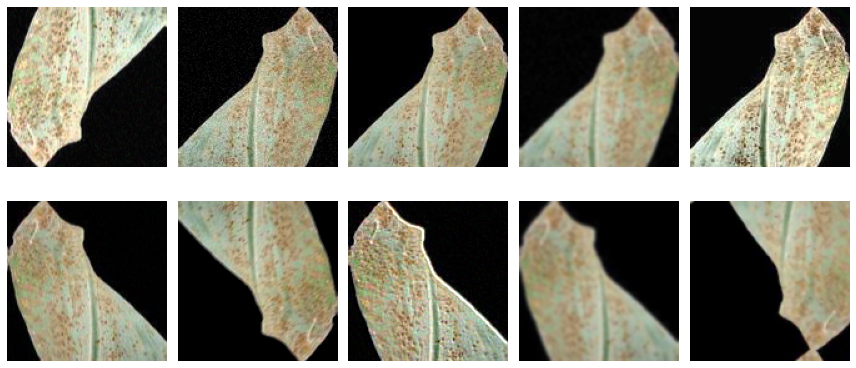

<IPython.core.display.Javascript object>

In [12]:
dataset = PlantDataset(df, tfms=args["trn_aug"])
idx = np.random.randint(len(dataset))
visualize_tfms(dataset, idx)

## Model

In [13]:
class LabelSmoothingCrossEntropy(nn.Module):
    """
    NLL loss with label smoothing.
    """

    def __init__(self, smoothing=0.1):
        """
        Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


class SoftTargetCrossEntropy(nn.Module):
    def __init__(self):
        super(SoftTargetCrossEntropy, self).__init__()

    def forward(self, x, target):
        loss = torch.sum(-target * F.log_softmax(x, dim=-1), dim=-1)
        return loss.mean()

<IPython.core.display.Javascript object>

In [14]:
class Backbone(nn.Module):
    def __init__(self, name="resnet18", pretrained=True):
        super().__init__()
        self.net = timm.create_model(name, pretrained=pretrained)

        if "regnet" in name:
            self.out_features = self.net.head.fc.in_features
        elif "csp" in name:
            self.out_features = self.net.head.fc.in_features
        elif "res" in name:  # works also for resnest
            self.out_features = self.net.fc.in_features
        elif "efficientnet" in name:
            self.out_features = self.net.classifier.in_features
        elif "densenet" in name:
            self.out_features = self.net.classifier.in_features
        elif "senet" in name:
            self.out_features = self.net.fc.in_features
        elif "inception" in name:
            self.out_features = self.net.last_linear.in_features
        else:
            self.out_features = self.net.classifier.in_features

    def forward(self, x):
        x = self.net.forward_features(x)

        return x


class Net(nn.Module):
    def __init__(self, args, pretrained=True):
        super().__init__()
        self.args = args
        self.backbone = Backbone(args["backbone"])
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.head1 = nn.Linear(self.backbone.out_features, args["num_plants"])
        self.head2 = nn.Linear(self.backbone.out_features, args["num_diseases"])

    def forward(self, x):
        x = self.backbone(x)

        x = self.global_pool(x)
        x = x[:, :, 0, 0]

        x1 = self.head1(x)
        x2 = self.head2(x)

        return {"plant": x1, "disease": x2}

<IPython.core.display.Javascript object>

In [15]:
class Model(pl.LightningModule):
    def __init__(self, trn_dl, val_dl):
        super().__init__()
        self.trn_dl = trn_dl
        self.val_dl = val_dl
        self.lr = args["lr"]
        self.num_train_steps = math.ceil(
            len(self.trn_dl) / args["gradient_accumulation_steps"]
        )

        self.model = Net(args)

        self.criterion = LabelSmoothingCrossEntropy()
        self.val_f1_plant = pl.metrics.Fbeta(num_classes=args["num_plants"], beta=1)
        self.val_f1_disease = pl.metrics.Fbeta(num_classes=args["num_diseases"], beta=1)

    def forward(self, x):
        return self.model(x)

    def shared_step(self, batch, batch_nb):
        img = batch["img"]
        plant = batch["plant"]
        disease = batch["disease"]

        output_dict = self(img)

        loss_plant = self.criterion(output_dict["plant"], plant)
        loss_disease = self.criterion(output_dict["disease"], disease)
        loss = 0.5 * loss_plant + 0.5 * loss_disease

        return loss, output_dict

    def training_step(self, batch, batch_nb):
        loss, _ = self.shared_step(batch, batch_nb)

        self.log("train_loss", loss)
        for i, param_group in enumerate(self.optimizer.param_groups):
            self.log(f"lr/lr{i}", param_group["lr"])

        return {"loss": loss}

    def validation_step(self, batch, batch_nb):
        target_plant = batch["plant"]
        target_disease = batch["disease"]
        loss, output_dict = self.shared_step(batch, batch_nb)

        logits_plant = output_dict["plant"]
        logits_disease = output_dict["disease"]

        self.val_f1_plant(logits_plant, target_plant)
        self.val_f1_disease(logits_disease, target_disease)

        return {"loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([o["loss"] for o in outputs]).mean()
        f1 = 0.5 * self.val_f1_plant.compute() + 0.5 * self.val_f1_disease.compute()
        self.val_f1_plant.reset()
        self.val_f1_disease.reset()
        self.log("val_f1", f1)
        print(f"Epoch: {self.current_epoch} | Loss: {avg_loss} | F1: {f1}")

    def configure_optimizers(self):
        self.optimizer = AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=args["weight_decay"]
        )
        self.scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=self.num_train_steps * args["scheduler"]["warmup_epochs"],
            num_training_steps=int(self.num_train_steps * args["max_epochs"]),
        )

        return [self.optimizer], [{"scheduler": self.scheduler, "interval": "step"}]

    def train_dataloader(self):
        return self.trn_dl

    def val_dataloader(self):
        return self.val_dl

<IPython.core.display.Javascript object>

## Train

In [16]:
pl.seed_everything(args["seed"])

for fold in range(5):
    trn_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    trn_ds = PlantDataset(trn_df, tfms=args["trn_aug"])
    val_ds = PlantDataset(val_df, tfms=args["val_aug"])

    trn_dl = DataLoader(
        trn_ds,
        batch_size=args["batch_size"],
        sampler=RandomSampler(trn_ds),
        num_workers=args["num_workers"],
        pin_memory=True,
    )
    val_dl = DataLoader(
        val_ds,
        batch_size=2 * args["batch_size"],
        sampler=SequentialSampler(val_ds),
        num_workers=args["num_workers"],
        pin_memory=True,
    )

    model = Model(trn_dl=trn_dl, val_dl=val_dl)
    trainer = pl.Trainer(
        gpus=1,
        max_epochs=args["max_epochs"],
        precision=args["precision"],
        accumulate_grad_batches=args["gradient_accumulation_steps"],
    )
    trainer.fit(model)
    break

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name           | Type                       | Params
--------------------------------------------------------------
0 | model          | Net                        | 27 M  
1 | criterion      | LabelSmoothingCrossEntropy | 0     
2 | val_f1_plant   | Fbeta                      | 0     
3 | val_f1_disease | Fbeta                      | 0     


Epoch: 0 | Loss: 2.370882034301758 | F1: 0.138671875


Epoch: 0 | Loss: 0.7056301832199097 | F1: 0.9360937476158142


/home/isleof/.pyenv/versions/miniconda3-latest/envs/torch2/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Epoch: 1 | Loss: 0.602578341960907 | F1: 0.9690625071525574


Epoch: 2 | Loss: 0.5733242630958557 | F1: 0.9792187213897705


Epoch: 3 | Loss: 0.5515540242195129 | F1: 0.9846874475479126


Epoch: 4 | Loss: 0.5746201872825623 | F1: 0.9750000238418579


Epoch: 5 | Loss: 0.5412675142288208 | F1: 0.987500011920929


Epoch: 6 | Loss: 0.5412367582321167 | F1: 0.9884375333786011


Epoch: 7 | Loss: 0.5306570529937744 | F1: 0.9918749928474426


Epoch: 8 | Loss: 0.5246149897575378 | F1: 0.9945312738418579


Epoch: 9 | Loss: 0.5242853760719299 | F1: 0.9943749904632568


Epoch: 10 | Loss: 0.5272566676139832 | F1: 0.9928125143051147


Epoch: 11 | Loss: 0.5462091565132141 | F1: 0.9835937023162842


Epoch: 12 | Loss: 0.5226850509643555 | F1: 0.9937499761581421


Epoch: 13 | Loss: 0.5190039873123169 | F1: 0.9957812428474426


Epoch: 14 | Loss: 0.5210137367248535 | F1: 0.9946874976158142


Epoch: 15 | Loss: 0.5152348875999451 | F1: 0.9967187643051147


Epoch: 16 | Loss: 0.5169734954833984 | F1: 0.9965624809265137


Epoch: 17 | Loss: 0.5160294771194458 | F1: 0.9962499737739563


Epoch: 18 | Loss: 0.5135668516159058 | F1: 0.9971874952316284


Epoch: 19 | Loss: 0.5145189762115479 | F1: 0.9970312118530273


Epoch: 20 | Loss: 0.512712299823761 | F1: 0.9971874952316284


Epoch: 21 | Loss: 0.5116243362426758 | F1: 0.9979687333106995


Epoch: 22 | Loss: 0.5113922357559204 | F1: 0.9984375238418579


Epoch: 23 | Loss: 0.5100977420806885 | F1: 0.9982812404632568


Epoch: 24 | Loss: 0.5112364292144775 | F1: 0.9985937476158142


Epoch: 25 | Loss: 0.511795163154602 | F1: 0.9981249570846558


Epoch: 26 | Loss: 0.5113150477409363 | F1: 0.9982812404632568


Epoch: 27 | Loss: 0.5112637281417847 | F1: 0.9984375238418579


Epoch: 28 | Loss: 0.5111202001571655 | F1: 0.9984375238418579


Epoch: 29 | Loss: 0.5109842419624329 | F1: 0.9984375238418579



<IPython.core.display.Javascript object>